## TP6 -- Analyse 

In [1]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

# Custom
import common.plotting
import common.dataprocessing

### Partie 0 : Importation et visualisation des données avec UMAP

#### Importation des données

In [20]:
inf = "../data/TP6/TCGA_BRCA_fpkm_hv_norm_PAM50.h5"
dataset = h5py.File(inf)

In [31]:
# Extraires les différentes variables du jeux de données
brca_data = dataset["data"][:,:]
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str) # Type de tissus dans TCGA
print(brca_data.shape)

(11802, 1023)


### Partie I: Visualisation avec UMAP

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, labels, test_size = 0.2)
#print(X_train)
print(X_train.shape)

(818, 11802)


In [5]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train) 
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)
print(X_tr_umap.shape)
#print(X_tr_umap)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sat Dec  2 15:34:31 2023 Construct fuzzy simplicial set
Sat Dec  2 15:34:33 2023 Finding Nearest Neighbors
Sat Dec  2 15:34:35 2023 Finished Nearest Neighbor Search
Sat Dec  2 15:34:38 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Dec  2 15:34:42 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
(818, 2)


In [11]:
# Processing des données
targets = np.unique(labels)
count_df = pd.DataFrame(brca_data).T
labels_df = pd.DataFrame(labels)

count_df["labels"] = labels

print(count_df["labels"])

0         LumB
1         Her2
2         LumB
3       Normal
4       Normal
         ...  
1018      LumA
1019    Normal
1020    Normal
1021    Normal
1022      LumB
Name: labels, Length: 1023, dtype: object


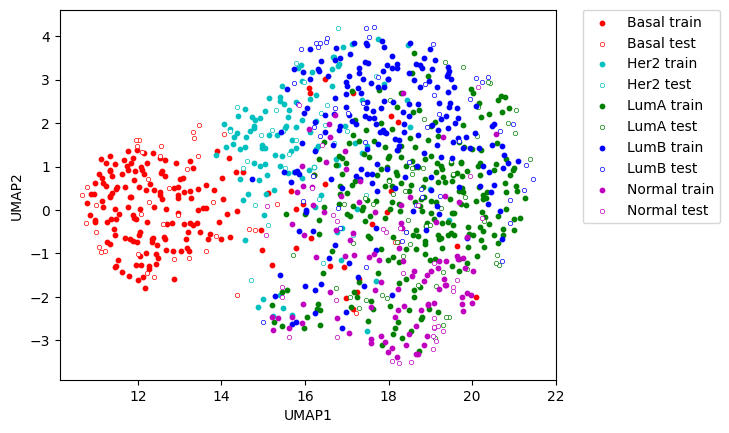

In [7]:
# Faire afficher dans un graphique
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

targets = list(np.unique(labels))
colors = ["r", "c", "g", "b", "m"]

plt.figure()
for target, color in zip(targets, colors): 
    target_label_train = target + " train"
    target_label_test = target + " test"
    plt.scatter(X_tr_umap_df.loc[Y_train == target,0], X_tr_umap_df.loc[Y_train == target, 1], 
                color = color, s = 10, label = target_label_train)
    plt.scatter(X_tst_umap_df.loc[Y_test == target,0], X_tst_umap_df.loc[Y_test == target, 1], 
                s = 10, edgecolors = color, color ="white", linewidth = 0.5, label = target_label_test)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
#plt.axis("equal")
plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1.02))
#X_train_umap[Y_train ==lbl,0]

### Partie II : Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur.

#### 1. Initialiser le réseau selon la structure encoder => bottleneck => decoder.


Hyper-paramètres : <br>
- 6 couches avec fonction d'activation ReLU (sauf la couche centrale) <br>
- Optimiseur Adam (pénalité "weight decay" de 0.001) <br>
- Entraînement de 1000 itérations (époques)

In [5]:
import torch
from torch import nn

In [20]:
# Transformation des données initiales
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

In [21]:
def buildModel(inSize, outSize, width, bnSize) :

    model = nn.Sequential(
        nn.Linear(inSize, width),
        nn.ReLU(),
        nn.Linear(width, width),
        nn.ReLU(),
        nn.Linear(width, bnSize), # couche centrale
        nn.Linear(bnSize, width),
        nn.ReLU(),
        nn.Linear(width, outSize),
    )

    return model, model[0:5]


#### 2. Entraînement et performance du modèle

In [22]:
def trainModel(model, X_train, X_test, Y_train, Y_test, epochs, adamPenalty) : 

    optimizer = torch.optim.Adam(model.parameters(), lr = adamPenalty, weight_decay = adamPenalty)
    trainLosses, testLosses, trainAccs, testAccs = [], [], [], []

    for epoch in range(epochs) :

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = model(X_train)
        outTest = model(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), Y_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), Y_test.flatten().detach().numpy()).statistic

        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc)), testAccs.append(float(testAcc))]

        trainError.backward()
        optimizer.step()

        if epoch % 10 == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc), 2)} ~ Test Acc : {round(float(testAcc), 2)} ")

    return trainLosses, testLosses, trainAccs, testAccs



In [23]:
# Test de modèle
mm, ae = buildModel(X_train.shape[1], Y_train.shape[1], 100, 2) # Tu peux aussi mettre le buid model directement dans la fontion train aussi si ça te tente
trainMSE, testMSE, trainCorr, testCorr = trainModel(mm, X_train, X_test, Y_train, Y_test, 200, 0.001)

Epoch 0 --- Train Error : 0.3 ~ Test Error : 0.3 ~ Train Acc : -0.14 ~ Test Acc : -0.12 
Epoch 10 --- Train Error : 0.17 ~ Test Error : 0.17 ~ Train Acc : -0.06 ~ Test Acc : -0.04 
Epoch 20 --- Train Error : 0.16 ~ Test Error : 0.15 ~ Train Acc : 0.21 ~ Test Acc : 0.21 
Epoch 30 --- Train Error : 0.14 ~ Test Error : 0.15 ~ Train Acc : 0.41 ~ Test Acc : 0.32 
Epoch 40 --- Train Error : 0.11 ~ Test Error : 0.12 ~ Train Acc : 0.56 ~ Test Acc : 0.48 
Epoch 50 --- Train Error : 0.09 ~ Test Error : 0.11 ~ Train Acc : 0.64 ~ Test Acc : 0.58 
Epoch 60 --- Train Error : 0.08 ~ Test Error : 0.1 ~ Train Acc : 0.69 ~ Test Acc : 0.62 
Epoch 70 --- Train Error : 0.07 ~ Test Error : 0.09 ~ Train Acc : 0.73 ~ Test Acc : 0.65 
Epoch 80 --- Train Error : 0.06 ~ Test Error : 0.08 ~ Train Acc : 0.78 ~ Test Acc : 0.71 
Epoch 90 --- Train Error : 0.06 ~ Test Error : 0.09 ~ Train Acc : 0.8 ~ Test Acc : 0.68 
Epoch 100 --- Train Error : 0.05 ~ Test Error : 0.08 ~ Train Acc : 0.83 ~ Test Acc : 0.72 
Epoch 110 

ValueError: x and y must have same first dimension, but have shapes (200,) and (20000,)

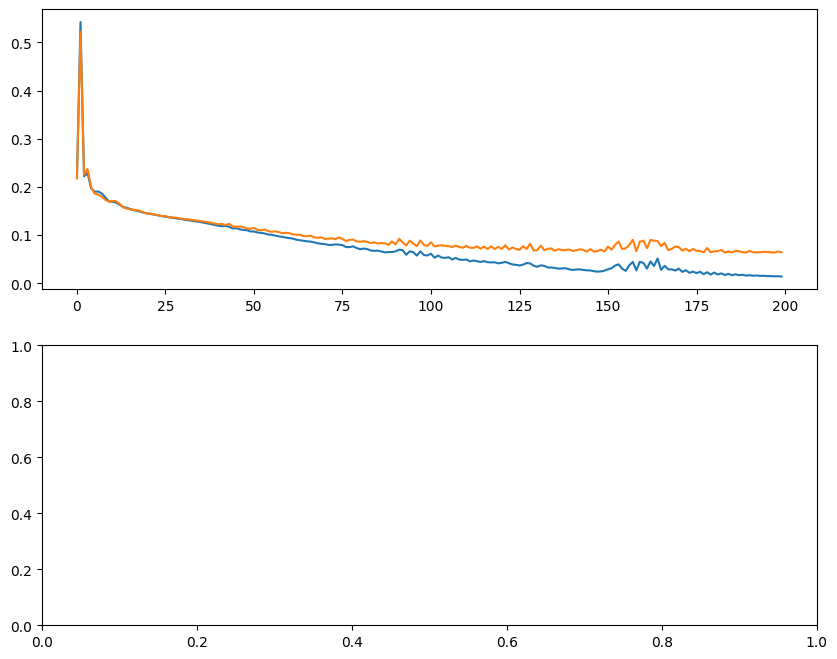

### Partie III Implémentation d'un Variational Auto-Encoders (VAE)

In [6]:
import torch.nn.functional as F
import torch.nn as nn
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [13]:
mm = VariationalAutoencoder(insize, 2)

In [14]:
mm(X_train)

tensor([[-0.1020,  0.0595,  0.2166,  ..., -0.0385, -0.0103, -0.1941],
        [-0.0668, -0.1786,  0.1912,  ...,  0.7393,  0.1356, -0.3973],
        [-0.0491, -0.0713,  0.1775,  ...,  0.4407,  0.1529, -0.3095],
        ...,
        [-0.0465, -0.0897,  0.2065,  ...,  0.1808,  0.1226, -0.3145],
        [ 0.0167, -0.1744,  0.4207,  ...,  0.4314,  0.0383, -0.5657],
        [-0.0608, -0.0664,  0.2047,  ...,  0.1541,  0.1159, -0.3105]],
       grad_fn=<AddmmBackward0>)

In [49]:
def train_Variational_Autoencodeur (insize, bnsize, X_train, X_test, nepochs = 1000, printstep=100, wd = 1e-3, lr = 0.0001):
    DNN = VariationalAutoencoder(insize, bnsize)
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    trainLosses, testLosses, trainAccs, testAccs = [],[],[],[]
    
    for epoch in range(nepochs):

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = DNN(X_train)
        outTest = DNN(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        trainError.backward()
        optimizer.step()

        if epoch % printstep == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc*100), 2)} ~ Test Acc : {round(float(testAcc*100), 2)} ")

        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc*100)), testAccs.append(float(testAcc*100))]
    return trainLosses, testLosses, trainAccs, testAccs


In [50]:
lblbin = LabelBinarizer() 
targets = lblbin.fit_transform(labels) 
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(targets),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
tr_losses, tst_losses, tr_accs, tst_accs = train_Variational_Autoencodeur(insize, 2, X_train, X_test)

Epoch 0 --- Train Error : 0.24 ~ Test Error : 0.24 ~ Train Acc : 0.34 ~ Test Acc : 0.33 
Epoch 100 --- Train Error : 0.14 ~ Test Error : 0.14 ~ Train Acc : 8.78 ~ Test Acc : 8.84 
Epoch 200 --- Train Error : 0.1 ~ Test Error : 0.1 ~ Train Acc : 20.51 ~ Test Acc : 20.74 
Epoch 300 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 61.27 ~ Test Acc : 61.91 
Epoch 400 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 65.89 ~ Test Acc : 66.62 
Epoch 500 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.07 ~ Test Acc : 66.8 
Epoch 600 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.11 ~ Test Acc : 66.85 
Epoch 700 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.14 ~ Test Acc : 66.87 
Epoch 800 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.15 ~ Test Acc : 66.88 
Epoch 900 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.17 ~ Test Acc : 66.9 


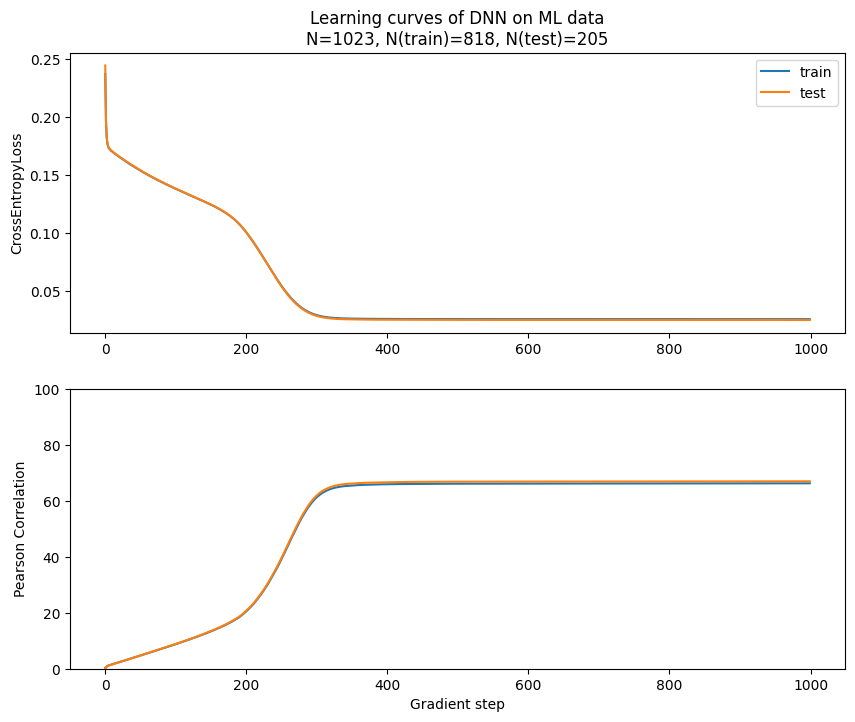

In [51]:
# Courbe d'apprentissage
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc, label = "train")
    axes[1].plot(steps, tstc, label= "test")
    axes[0].set_ylabel("CrossEntropyLoss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on ML data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")
    #plt.savefig(f"figures/DNN_learning_curves{str(datetime.datetime.now())}.pdf")
    
plot_learning_curves(tr_losses, tst_losses, tr_accs, tst_accs, brca_data, X_train, X_test)

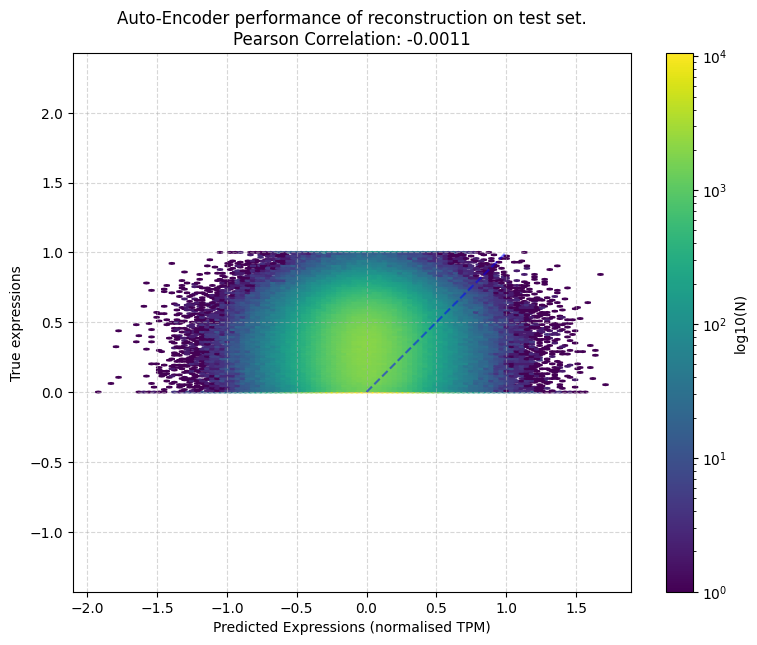

In [54]:
# Visualisation avec un diagramme de densité
common.plotting.plot_ae_performance(mm, X_test) # À modifier 